In [1]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ot

from multiprocessing import Pool
import datetime
from pathlib import Path

In [2]:
import sys
sys.path.append(str(Path().resolve().parent))

In [3]:
from QFTSampler import Orchestrator
from QFTSampler.transformers import *
from QFTSampler.transformers.Densenet import *
from QFTSampler.ExpTargetDists import *

In [4]:
N, M = 10, 4

In [5]:
one_dim_target = [Target_gauss_flat(N,M), Target_gauss_sharp(N,M), 
                  Target_gauss_multi(N,M), Target_gauss_multi2(N,M), 
                  Target_step(N,M), ]
two_dim_target = [Target_checker_booard(N,M), Target_circle2d(N,M), Target_gauss2d_dependent(N,M), 
                  Target_gauss2d_independent(N,M), Target_gauss2d_multi(N,M), Target_linear2d(N,M), 
                  ANPAN(N,5), ]
md_target = [Target_LJ2(N,M), ]

In [6]:
target_dist = {1:one_dim_target, 2:two_dim_target, 6:md_target}

# Target Dists

## 1dim

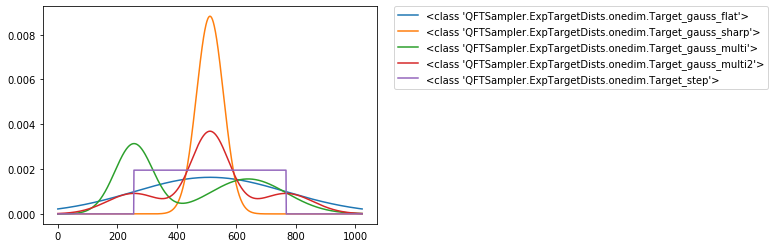

In [7]:
def pmap_1d(target, stride):
    xst = np.arange(0,2**N,stride)
    target_samples_list = [ each.flatten() for each in [xst] ]
    pxy = target( *target_samples_list )
    return pxy.reshape(len(xst))

for target in one_dim_target:
    px= pmap_1d(target,stride=1)
    plt.plot(px, label=str(type(target)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## 2dim

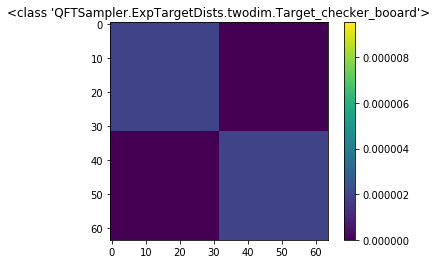

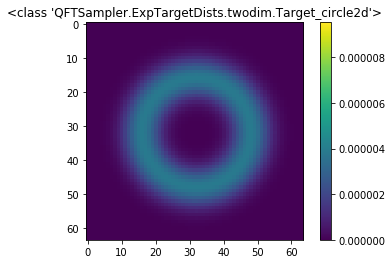

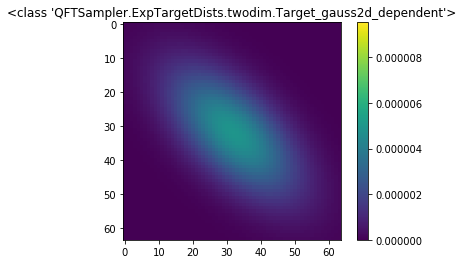

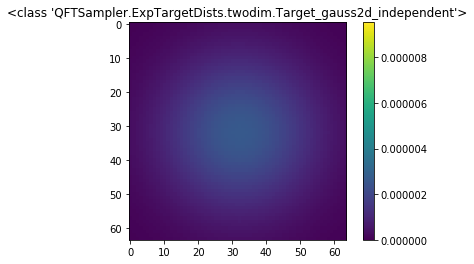

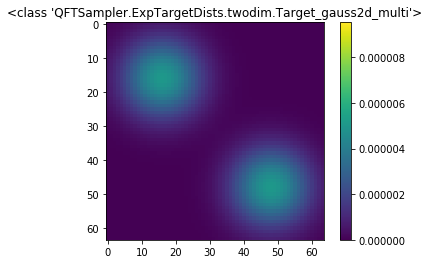

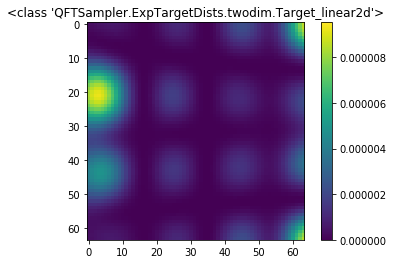

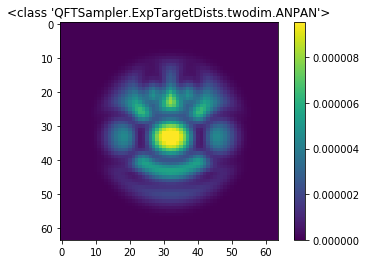

In [8]:
def pmap_2d(target, stride):
    xst = np.arange(0,2**N,stride)
    yst = np.arange(0,2**N,stride)
    target_samples_list = [ each.flatten() for each in np.meshgrid(xst,yst) ]
    pxy = target(*target_samples_list )
    return pxy.reshape(len(xst),len(yst))

for target in two_dim_target:
    pxy = pmap_2d(target,stride=16)
    plt.imshow(pxy,vmax= 1/(2**(2*N)) * 10 , vmin= 0.)
    plt.title(str(type(target)))
    plt.colorbar()
    plt.show()

In [9]:
from IPython.display import display, clear_output
def redraw():
    clear_output(wait = True)

In [10]:
def make_file_name(target, transformer_list):
    tag = str(type(target)).split(".")[-1].rstrip("'>")
    tra = "_".join([ it.__class__.__name__ for it in transformer_list])
    name = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    return name

class AutoTest():
    def __init__(me, orch, dim=1, skip=1000, sid_post='', resume_dir=None, ):
        me.SKIP = skip
        me.q = 1e10
        me.p = 1e-10
        me.rej = 1
        me.acc = 0
        if resume_dir is None:
            me.orch = orch
            me.dim = dim
            me.i = 0
            me.CE = []
            me.WA = []
            me.QL = None
            me.AC = []
            me.target = me.orch.target
            tag = str(type(me.target)).split(".")[-1].rstrip("'>")
            tra = "_".join([ it.__class__.__name__ for it in me.orch.transformer_list])
            sid = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+sid_post
            
            
            
            me.dir = Path().resolve()/'data'/ (tag +"_"+tra+"_"+sid)
            me.dir.mkdir(parents=True)
        else:
            me.load(resume_dir)
        
    def step(me,*arg,**args):
        me.i += 1
        if (me.i%me.SKIP) == 0:
            me.save(args)
        if ( me.i < me.SKIP ):
            args["train"] = False
        ret =  me.orch.step(*arg,**args)
        samples = ret[1]
        #print (samples,samples.shape)
        ql,pl = ret[0],me.target(*samples.T)
        #print (ql,pl)
        for q,p in zip(ql,pl):
            #print (q,p)
            r = p*me.q/(me.p*q)
            if r>np.random.rand():
                me.p,me.q = p,q
                me.acc += 1
                #print ("acc")
            else:
                me.rej += 1
                #print ("rej") 
        return ret
    def save(me,save_args):
        if me.dim == 1:
            st = 1
        elif me.dim == 2:
            st = 16
        else:
            one_dim_sample = (1e+4)**(1/me.dim)
            st = 2**N//one_dim_sample
        pm = me.orch.pmap(stride=st,)
        qm = me.orch.pmap(stride=st,)
            
        me.QL= qm.copy()

        # Cross Entropy
        CE = -np.sum( pm * np.log(qm) )
        me.CE.append(CE)
        
        # Wasserstein Distance 
        if me.dim == 1:
            x = np.linspace(-1,1, pm.shape[0] )
            y = np.linspace(-1,1, pm.shape[0] )
            xx,yy = np.meshgrid(x,y)
            M = np.abs(xx-yy)
            WA, = ot.sinkhorn2( pm + 1e-10 , qm + 1e-10 , M, 1e-2)
        elif me.dim == 2:
            WA = 0.
            x = np.linspace(-1,1,pm.shape[0])
            y = np.linspace(-1,1,pm.shape[1])
            xx,yy = np.meshgrid(x,y)
            xx,yy = xx.flatten(), yy.flatten()
            x1,x2 = np.meshgrid(xx,xx)
            y1,y2 = np.meshgrid(yy,yy)
            M = np.sqrt( np.square(x1-x2) + np.square(y1-y2) )
            WA, = ot.sinkhorn2( pm.flatten() + 1e-10 , qm.flatten() + 1e-10 , M, 1e-2)
        else:
            # WA is not calculated on more than 2 dim target dist
            WA = -1
            
            
        me.WA.append(WA)
        
        me.AC.append( me.acc/(me.acc+me.rej) )
        me.acc = 0
        me.rej = 0
        
        redraw()
        plt.subplot(311)
        plt.plot (me.CE)
        plt.subplot(312)
        plt.plot (me.WA)
        plt.subplot(313)
        plt.plot (me.AC)
        plt.show()
        
        file =  str(me.dir /("{0:07d}".format(me.i)))
        np.savez(file+".npz",**{"i":me.i,"QL":me.QL,"CE":me.CE,"WA":me.WA,"AC":me.AC,"o":save_args},allow_pickle=True)
        me.orch.save(file+'.orch')
        print ("saved at" + file)
        
    def load(me, directory):
        directory = Path(directory)
        me.dir = directory
        recent_orch = sorted(list(map(lambda x:x.name if x.suffix=='.orch' else '00000', directory.iterdir())))[-1]
        recent_npz = sorted(list(map(lambda x:x.name if x.suffix=='.npz' else '00000', directory.iterdir())))[-1]
        me.orch = load_orchestrator(str(directory/recent_orch))
        me.target = me.orch.target
        npz = np.load(str(directory/recent_npz)) 
        me.CE = npz['CE'].tolist()
        me.AC = npz['AC'].tolist()
        me.WA = npz['WA'].tolist()
        me.dim = npz['QL'].ndim
        me.i = npz['i']

In [11]:
def make_densenet(in_dim=1, N=N, M=M, lr = 1e-2, ):
    act = Sigmoid
    def dense2(_in, _out, _mid, activation, input_layers=[]):
        d1 = DenseLayer(_in, _mid, activation=activation, input_layers=input_layers)
        d2 = DenseLayer(_mid, _out, activation=None, input_layers=[d1])
        return d1,d2
    out_dim = (2**M)*2
    node_num = max(out_dim*2, 256)
    d1 = DenseLayer(in_dim, out_dim, activation=None, )
    a1 = act(input_layers=[d1])
    d2 = DenseLayer(out_dim, out_dim, input_layers=[a1], )
    a2 = act(input_layers=[d2])
    d3 = DenseLayer(out_dim, out_dim, input_layers=[a2], )
    a3 = act(input_layers=[d3])
    d4 = DenseLayer(out_dim, out_dim, input_layers=[a3], )
    iden = IdentityLayer(input_layers=[d4, ])
    model = Model(inputs=[d1], outputs=[iden])

    for l in [d4]:
        l.w.var *= 1e-4
        l.b.var[0] = 1
    densenet = Densenet(N,M,1,model=model, optimizer=Momentum, )
    
    return densenet

In [12]:
def _do(argv, ):
    i = argv[0]
    lr = argv[1]
    iter_num = argv[2] # 400000
    skip = argv[3] # 1000
    bs = argv[4]
    target = argv[5]
    transformer_list = argv[6]
    M = argv[7]
    np.random.seed(i*np.random.randint(1,2^30)%(2^32))
    print(N, M, target, transformer_list[-1])
    orch=Orchestrator(N,M,transformer_list,target)
    autotest = AutoTest(orch, dim=len(transformer_list), skip=skip,)
    for i in tqdm(range(iter_num), leave=False):
        _q,_sample = autotest.step(lr=lr,sample_num=32,train=True,loss_func='CE' )
    return 

In [13]:
arglist = []
for dim in target_dist.keys():
    for target in target_dist[dim]:
        iter_num = 10#10000 if isinstance(target, Target_LJ2) else 40000
        skip = 5#5 if isinstance(target, Target_LJ2) else 1000
        bs = 1024 if isinstance(target, Target_LJ2) else 32 
        M = 5 if isinstance(target, ANPAN) else 4
        if dim==1:
            lr = 1e-2
            arglist.append([len(arglist), lr, iter_num, skip, bs, target, [Constant(M=M)], M])
        else:
            for T in [lambda n: Constant(M=M), 
                      lambda n: AffineLinearBasis(N=N, M=M),
                      lambda n: AffineNonLinearBasis(N=N, M=M),
                      lambda n: make_densenet(in_dim=n, N=N, M=M)]:
                transformers_list = [Constant(M=M),]+[T(n) for n in range(1,dim)]
                if dim == 1:
                    lr = 1e-2
                else:
                    if isinstance(target, ANPAN):
                        lr = 1e-2
                    if isinstance(target, Target_LJ2):
                        lr = 10
                        if isinstance(transformers_list[1], Densenet):
                            lr = 0.1
                    else:
                        lr = 1e-2
                        if isinstance(transformers_list[1], Densenet):
                            lr = 1e-3
                arglist.append([len(arglist), lr, iter_num, skip, bs, target, transformers_list, M])

In [14]:
print(len(arglist))

37


In [15]:
Orchestrator(N=N, M=M, transformer_list=[Constant(M=M), ], target=Target_step(N=N, M=M))

In [16]:
help(Orchestrator)

Help on class Orchestrator in module QFTSampler.Orchestrator:

class Orchestrator(builtins.object)
 |  Orchestrator(N, M, transformer_list, target)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, N, M, transformer_list, target)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  pmap(self, stride=16)
 |  
 |  qmap(self, stride=16)
 |  
 |  save(self, filename)
 |  
 |  step(self, train=True, sample_num=64, lr=1, loss_func='CE')
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



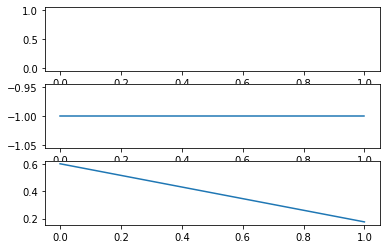

saved at/home/taichi/git/QFTSampler/demo/data/Target_LJ2_Constant_Densenet_Densenet_Densenet_Densenet_Densenet_20200206_022509/0000010



In [21]:
jobs = 10 #マルチプロセス数
with Pool(jobs) as p:
    with tqdm(p.imap_unordered(_do, arglist), total=len(arglist), disable=False) as pbar:
        for res in pbar:
            pbar.set_postfix_str(res)

In [18]:
def make_all(d, step=1000):
    d = Path(d)
    recent_npz = sorted(list(map(lambda x:x.name if x.suffix=='.npz' else '00000', d.iterdir())))[-1]
    recent_npz = np.load(str(d/recent_npz), allow_pickle=True)
    QL = recent_npz['QL']
    QL_list = np.empty( (len(list(d.glob('*.npz'))), *QL.shape) )
    print('start')
    for file in tqdm(d.glob('*.npz'), total=QL_list.shape[0], leave=False):
        tmp = np.load(str(file))
        QL = tmp['QL']
        QL_list[int(tmp['i'])//step-1] = QL
    
    di = {s:recent_npz[s] for s in ['i', 'CE', 'WA', 'AC', 'o']}
    di['QL'] = QL_list
    save_file = str(d.parent)+f'/{d.name}_all.npz'
    np.savez(save_file, **di,allow_pickle=True)
    print(save_file)

In [19]:
data_dir = Path('.').resolve()/'data'
list(data_dir.glob('*'))

[PosixPath('/home/taichi/git/QFTSampler/demo/data/.ipynb_checkpoints'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_AffineLinearBasis_20200205_233243'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_AffineLinearBasis_20200206_015109'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_AffineNonLinearBasis_20200205_233244'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_AffineNonLinearBasis_20200206_015140'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_Constant_20200205_233243'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_Constant_20200206_015037'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_Densenet_20200205_233244'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/ANPAN_Constant_Densenet_20200206_015212'),
 PosixPath('/home/taichi/git/QFTSampler/demo/data/Target_LJ2_Constant_AffineLinearBasis_AffineLinearBasis_AffineLinearBasis_AffineLinearBasis_